# Surf Project: Spatial Protein Expression Analysis for Identifying and Stratifying Resistant Subpopulations in Breast Cancer

All imports

In [1]:
import os
import sys
from pathlib import Path
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import cKDTree
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.utils import shuffle

from tqdm.notebook import tqdm

from itertools import combinations


file_path = "/Users/aditideshpande/Downloads/ctrl_wellB02_100palbo_wellC05_cc_annotated_normed_nuc_cyto_wc_means_stds_phase_probs250311.csv"

def load_and_prepare_data(file_path):
    """
    Load CSV data and prepare it by dropping NaNs and assigning palbo_condition.
    """
    data = pd.read_csv(file_path)
    data = data.dropna(subset=['centroid-0_nuc_r0', 'centroid-1_nuc_r0', 'cycling_bool'])
    data['palbo_condition'] = data['well_idx'].apply(lambda x: 'control' if 'B02' in str(x) else 'palbo')
    return data

## XY coordinates of all cells colored by cycling_bool parameter

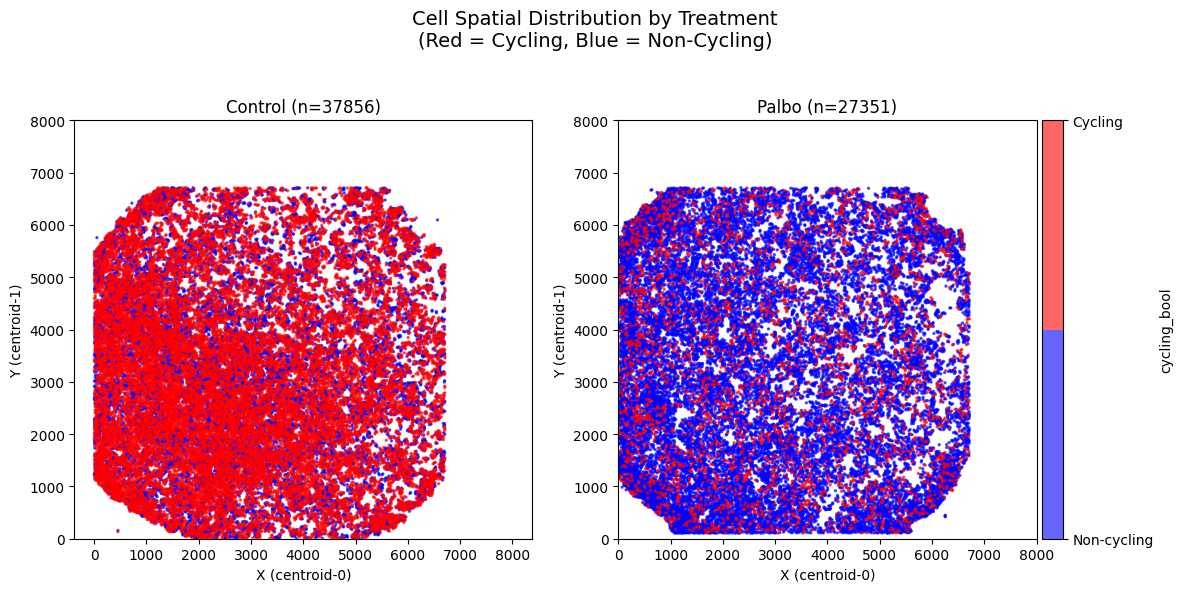

In [2]:

data = load_and_prepare_data(file_path)

def plot_cells_by_cycling(data, axis_limits=(0, 8000)):
    """
    Plot XY coordinates of all cells colored by cycling_bool, split by treatment condition.
    """
    conditions = sorted(data['palbo_condition'].unique())
    fig, axes = plt.subplots(1, len(conditions), figsize=(6 * len(conditions), 6))

    colors = ListedColormap(['blue', 'red'])

    for i, condition in enumerate(conditions):
        ax = axes[i] if len(conditions) > 1 else axes
        subset = data[data['palbo_condition'] == condition]

        scatter = ax.scatter(
            subset['centroid-0_nuc_r0'],
            subset['centroid-1_nuc_r0'],
            c=subset['cycling_bool'].astype(int),
            cmap=colors,
            s=2,
            alpha=0.6
        )

        ax.set_title(f"{condition.capitalize()} (n={len(subset)})")
        ax.set_xlabel("X (centroid-0)")
        ax.set_ylabel("Y (centroid-1)")
        ax.axis('equal')
        ax.set_xlim(*axis_limits)
        ax.set_ylim(*axis_limits)

        # Add colorbar only on last subplot
        if i == len(conditions) - 1:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cb = plt.colorbar(scatter, cax=cax, ticks=[0, 1])
            cb.set_label('cycling_bool')
            cb.ax.set_yticklabels(['Non-cycling', 'Cycling'])

    plt.suptitle("Cell Spatial Distribution by Treatment\n(Red = Cycling, Blue = Non-Cycling)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()

plot_cells_by_cycling(data)


## Overlay cycling cells on all cells

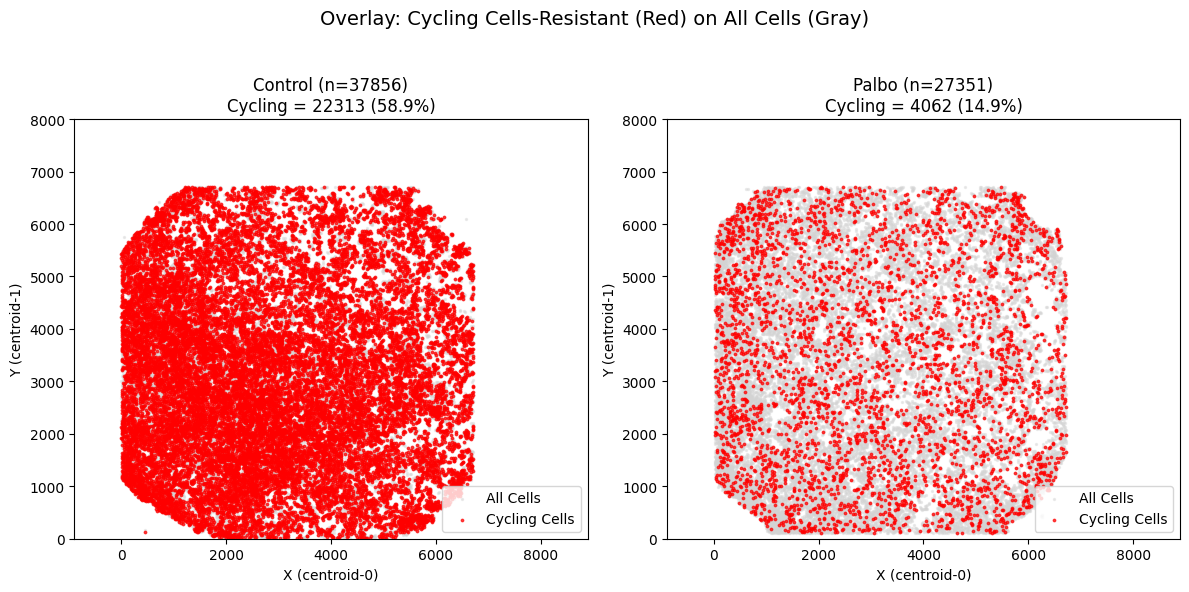

In [3]:
data = load_and_prepare_data(file_path)

def plot_overlay_cycling_on_all(data, axis_limits=(0, 8000)):
    """
    Overlay plot of cycling cells (red) on all cells (gray) per treatment condition.
    """
    conditions = sorted(data['palbo_condition'].unique())
    fig, axes = plt.subplots(1, len(conditions), figsize=(6 * len(conditions), 6))

    for i, condition in enumerate(conditions):
        ax = axes[i] if len(conditions) > 1 else axes

        all_cells = data[data['palbo_condition'] == condition]
        cycling_cells = all_cells[all_cells['cycling_bool'] == 1]

        ax.scatter(
            all_cells['centroid-0_nuc_r0'],
            all_cells['centroid-1_nuc_r0'],
            c='lightgray', s=2, alpha=0.4, label='All Cells'
        )
        ax.scatter(
            cycling_cells['centroid-0_nuc_r0'],
            cycling_cells['centroid-1_nuc_r0'],
            c='red', s=3, alpha=0.7, label='Cycling Cells'
        )

        percent_cycling = len(cycling_cells) / len(all_cells) * 100 if len(all_cells) > 0 else 0
        ax.set_title(f"{condition.capitalize()} (n={len(all_cells)})\nCycling = {len(cycling_cells)} ({percent_cycling:.1f}%)")
        ax.set_xlabel("X (centroid-0)")
        ax.set_ylabel("Y (centroid-1)")
        ax.axis('equal')
        ax.set_xlim(*axis_limits)
        ax.set_ylim(*axis_limits)
        ax.legend(loc='lower right')

    plt.suptitle("Overlay: Cycling Cells-Resistant (Red) on All Cells (Gray)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_overlay_cycling_on_all(data)

## Calculate and Visualize Radial Distribution Function G(r) for Cycling and Non-Cycling Cells

In [4]:
def check_required_columns(data, required_columns):
    """
    Verify that all required columns are present in the DataFrame.
    Raise ValueError if any are missing.
    """
    missing_cols = [col for col in required_columns if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {', '.join(missing_cols)}")


def assign_palbo_condition(data, control_identifier='B02'):
    """
    Assign a 'palbo_condition' column based on presence of control_identifier in 'well_idx'.
    """
    data['palbo_condition'] = data['well_idx'].apply(
        lambda x: 'control' if control_identifier in str(x) else 'palbo'
    )
    return data


def generate_normalization_points(real_points, factor=5):
    """
    Generate random points within the convex hull of real_points for normalization.
    For >3 dimensions, skips convex hull filtering (returns uniform random points).
    """
    mins = np.min(real_points, axis=0)
    maxs = np.max(real_points, axis=0)
    n_random_points = int(len(real_points) * factor)
    random_points = np.random.uniform(mins, maxs, (n_random_points, real_points.shape[1]))

    if real_points.shape[1] <= 3:
        hull = ConvexHull(real_points)
        hull_path = Delaunay(real_points[hull.vertices])
        inside_hull_idx = hull_path.find_simplex(random_points) >= 0
        filtered_random_points = random_points[inside_hull_idx]
    else:
        filtered_random_points = random_points

    return filtered_random_points


def calculate_radial_distribution(points, bins, chunk_size=1000, min_distance=0):
    """
    Calculate normalized histogram of pairwise distances between points using chunks.
    """
    histogram = np.zeros(len(bins) - 1)
    for i in range(0, len(points), chunk_size):
        chunk = points[i:i + chunk_size]
        distances = cdist(chunk, points)
        # Upper triangle distances to avoid duplicates & self-distances
        distances = np.triu(distances, k=1).flatten()
        distances = distances[distances > min_distance]
        histogram += np.histogram(distances, bins=bins)[0]

    total = histogram.sum()
    return histogram / total if total > 0 else histogram


def calculate_gor(real_points, bins, chunk_size=1000, random_points=None, factor=5, min_distance=0):
    """
    Calculate the radial distribution function G(r) = real_hist / random_hist.
    If random_points not given, generates them inside convex hull.
    """
    if random_points is None:
        random_points = generate_normalization_points(real_points, factor=factor)

    real_hist = calculate_radial_distribution(real_points, bins, chunk_size, min_distance)
    random_hist = calculate_radial_distribution(random_points, bins, chunk_size, min_distance)
    g_r = real_hist / (random_hist + 1e-10)  
    bin_midpoints = 0.5 * (bins[:-1] + bins[1:])
    return bin_midpoints, g_r


def bootstrap_gor(points, bins, n_boot=10, sample_frac=0.8):
    """
    Compute bootstrapped G(r) by sampling subsets of points with replacement.
    Returns an array of shape (n_boot, len(bins)-1)
    """
    all_g_r = []
    for _ in range(n_boot):
        sample_idx = np.random.choice(len(points), int(len(points) * sample_frac), replace=True)
        sample = points[sample_idx]
        _, g_r = calculate_gor(sample, bins)
        all_g_r.append(g_r)
    return np.array(all_g_r)


def plot_gor_by_cycling_status(data, cycling_status, title_suffix, output_filename,
                               r_bins=np.linspace(0, 500, 51), min_exclusion_distance=10,
                               max_points=10000, min_points=100):
    """
    Plot G(r) radial distribution function for cycling or non-cycling cells per condition.
    Saves the figure to output_filename.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))

    for condition in ['control', 'palbo']:
        subset = data[
            (data['palbo_condition'] == condition) &
            (data['cycling_bool'] == cycling_status)
        ].dropna(subset=['centroid-0_nuc_r0', 'centroid-1_nuc_r0'])

        coords = subset[['centroid-0_nuc_r0', 'centroid-1_nuc_r0']].to_numpy()

        if len(coords) < min_points:
            print(f"Skipping {condition} - not enough cells for status {cycling_status}")
            continue

        if len(coords) > max_points:
            coords = coords[np.random.choice(len(coords), max_points, replace=False)]

        bin_midpoints, g_r = calculate_gor(coords, r_bins, min_distance=min_exclusion_distance)
        bootstraps = bootstrap_gor(coords, bins=r_bins, n_boot=10)
        g_r_mean = np.mean(bootstraps, axis=0)
        g_r_std = np.std(bootstraps, axis=0)

        plt.plot(bin_midpoints, g_r_mean, label=f"{condition} (n={len(coords)})")
        plt.fill_between(bin_midpoints, g_r_mean - g_r_std, g_r_mean + g_r_std, alpha=0.3)

    label = "Cycling" if cycling_status == 1 else "Non-Cycling"
    plt.title(f"Radial Distribution Function G(r)\n{label} Cells {title_suffix}")
    plt.xlabel("Radius (r)")
    plt.ylabel("G(r)")
    plt.axhline(1, linestyle='--', color='gray', linewidth=1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    plt.show()

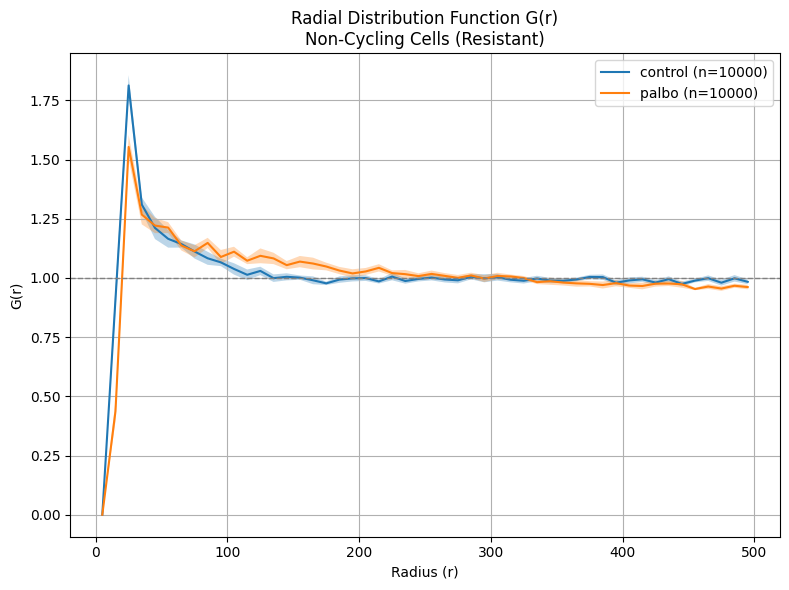

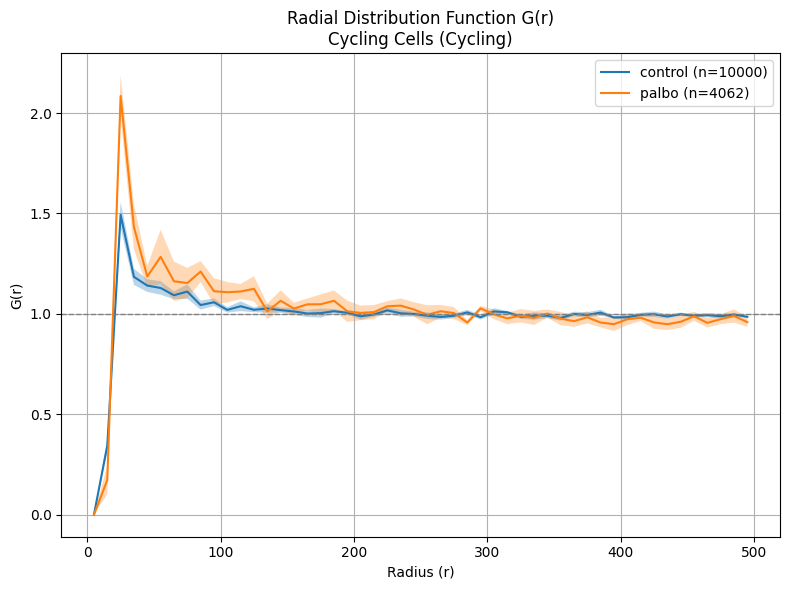

In [5]:
required_columns = ['centroid-0_nuc_r0', 'centroid-1_nuc_r0', 'cycling_bool', 'well_idx']
check_required_columns(data, required_columns)
data = assign_palbo_condition(data)

plot_gor_by_cycling_status(data, cycling_status=0, title_suffix="(Resistant)", output_filename="G_r_noncycling.png")
plot_gor_by_cycling_status(data, cycling_status=1, title_suffix="(Cycling)", output_filename="G_r_cycling.png")

## PCA on Resistant Cells to identify Top Features (Nuclear Intensity + DNA Content)

In [6]:
def assign_palbo_condition(data):
    """Assign palbociclib treatment condition based on well index."""
    data['palbo_condition'] = data['well_idx'].apply(lambda x: 'control' if 'B02' in str(x) else 'palbo')
    return data

def subset_resistant_cells(data):
    """Return only palbo-treated and cycling cells."""
    return data[(data['palbo_condition'] == 'palbo') & (data['cycling_bool'] == 1)].copy()

def get_nuclear_features(df):
    """Keep only nuclear intensity mean features and dna_content."""
    keep_cols = [col for col in df.columns if col.endswith('_intensity_mean_nuc')] + ['dna_content']
    return df[keep_cols].select_dtypes(include=[np.number])

def run_pca_and_get_top_features(X, n_components=2, top_n=20):
    """Standardize features, run PCA, and return top N contributing features."""
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components).fit(X_scaled)

    loadings_df = pd.DataFrame({
        'feature': X.columns,
        'PC1_loading': pca.components_[0],
        'PC2_loading': pca.components_[1],
        'combined_magnitude': np.sqrt(pca.components_[0]**2 + pca.components_[1]**2)
    })

    return loadings_df.sort_values(by='combined_magnitude', ascending=False).head(top_n)

# Run PCA Analysis for Resistant Cells 
# Assign palbo condition if not already done
data = assign_palbo_condition(data)

# Subset resistant (palbo-treated + cycling) cells
resistant_cells = subset_resistant_cells(data)

# Get relevant nuclear features
resist_features = get_nuclear_features(resistant_cells)

# Run PCA and extract top contributing features
top_20_features = run_pca_and_get_top_features(resist_features)

print("Top 20 Features Contributing to PCA (mean nuc features + dna_content):")
print(top_20_features[['feature', 'PC1_loading', 'PC2_loading', 'combined_magnitude']])

Top 20 Features Contributing to PCA (mean nuc features + dna_content):
                       feature  PC1_loading  PC2_loading  combined_magnitude
9     cycD1_intensity_mean_nuc     0.094404     0.423968            0.434351
8      E2F1_intensity_mean_nuc     0.135048     0.403806            0.425790
11    cycE1_intensity_mean_nuc     0.267837     0.224054            0.349195
7      Cdt1_intensity_mean_nuc    -0.012014     0.348146            0.348353
18                 dna_content     0.189362    -0.288170            0.344819
10     Ki67_intensity_mean_nuc     0.217445    -0.267561            0.344777
13  Geminin_intensity_mean_nuc     0.236893    -0.243842            0.339967
1       pRb_intensity_mean_nuc     0.252168    -0.198888            0.321162
4        ER_intensity_mean_nuc     0.283287     0.147992            0.319614
15     CDK4_intensity_mean_nuc     0.191303     0.255352            0.319063
0      DNA0_intensity_mean_nuc     0.266871    -0.161740            0.312058
14   

Narrow down to top 20 features to reduce noise in PCA.

## Spatial Clustering of Resistant Cell using DBSCAN

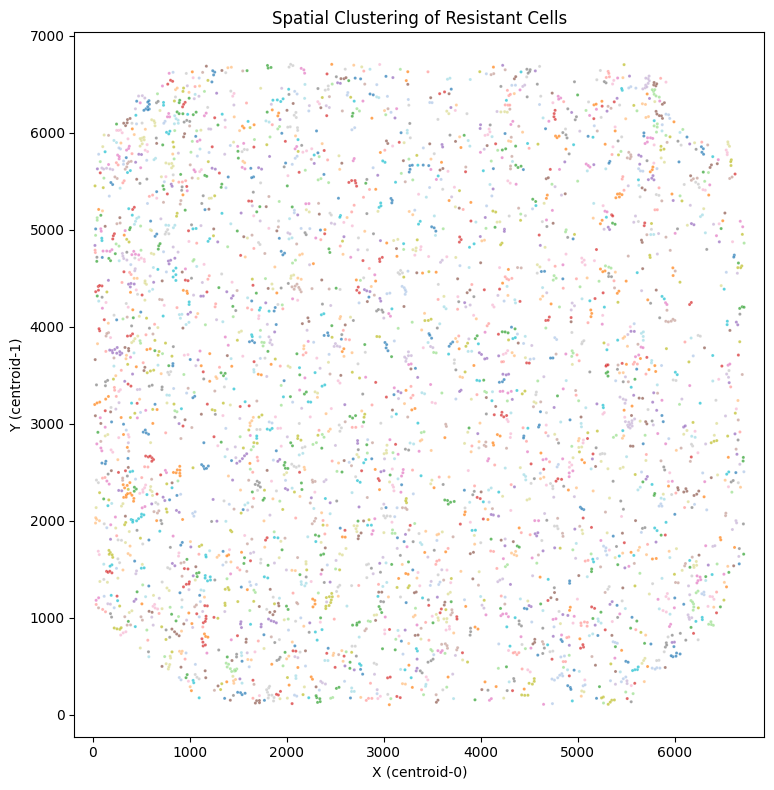

In [7]:
def spatial_clustering_and_plot(df, eps=40, min_samples=1):
    """
    Perform DBSCAN clustering on nuclear centroids and plot spatial distribution.
    
    Parameters:
        df (pd.DataFrame): DataFrame with centroid columns.
        eps (float): Maximum distance between two samples for them to be in the same neighborhood.
        min_samples (int): Minimum number of samples in a neighborhood to form a core point.

    Returns:
        pd.DataFrame: Input DataFrame with 'spatial_cluster' column added.
    """
    coords = df[['centroid-0_nuc_r0', 'centroid-1_nuc_r0']].to_numpy()
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    df['spatial_cluster'] = dbscan.fit_predict(coords)

    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        x='centroid-0_nuc_r0',
        y='centroid-1_nuc_r0',
        hue='spatial_cluster',
        data=df,
        palette='tab20',
        s=5,
        alpha=0.7,
        legend=False
    )
    plt.title("Spatial Clustering of Resistant Cells")
    plt.xlabel("X (centroid-0)")
    plt.ylabel("Y (centroid-1)")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    return df

resistant_cells = spatial_clustering_and_plot(resistant_cells)

## Analyze Molecular Heterogeneity Across Spatial Clusters

Gives statistical evidence of inter-cluster heterogeneity and a clear visual of marker expression differences -> useful for interpreting spatial dynamics in resistance.

ANOVA results across spatial clusters:

cycD1_intensity_mean_nuc            F=    1.66, p=2.99e-24
E2F1_intensity_mean_nuc             F=    1.88, p=9.70e-36
cycE1_intensity_mean_nuc            F=    3.45, p=6.91e-118
Cdt1_intensity_mean_nuc             F=    1.17, p=8.52e-04
dna_content                         F=    1.20, p=1.31e-04
Ki67_intensity_mean_nuc             F=    1.05, p=1.83e-01
Geminin_intensity_mean_nuc          F=    1.23, p=1.27e-05
pRb_intensity_mean_nuc              F=    1.29, p=1.23e-07
ER_intensity_mean_nuc               F=    3.46, p=2.35e-118
CDK4_intensity_mean_nuc             F=    2.06, p=1.63e-45
DNA0_intensity_mean_nuc             F=    1.63, p=1.96e-22
cycA2_intensity_mean_nuc            F=    1.93, p=2.83e-38
p21_intensity_mean_nuc              F=    1.77, p=9.01e-30
CDK2_intensity_mean_nuc             F=    2.43, p=1.59e-65
cycB1_intensity_mean_nuc            F=    1.44, p=1.78e-13
Rb_intensity_mean_nuc               F=    1.77, p=1.09e-29
PR_intensity_m

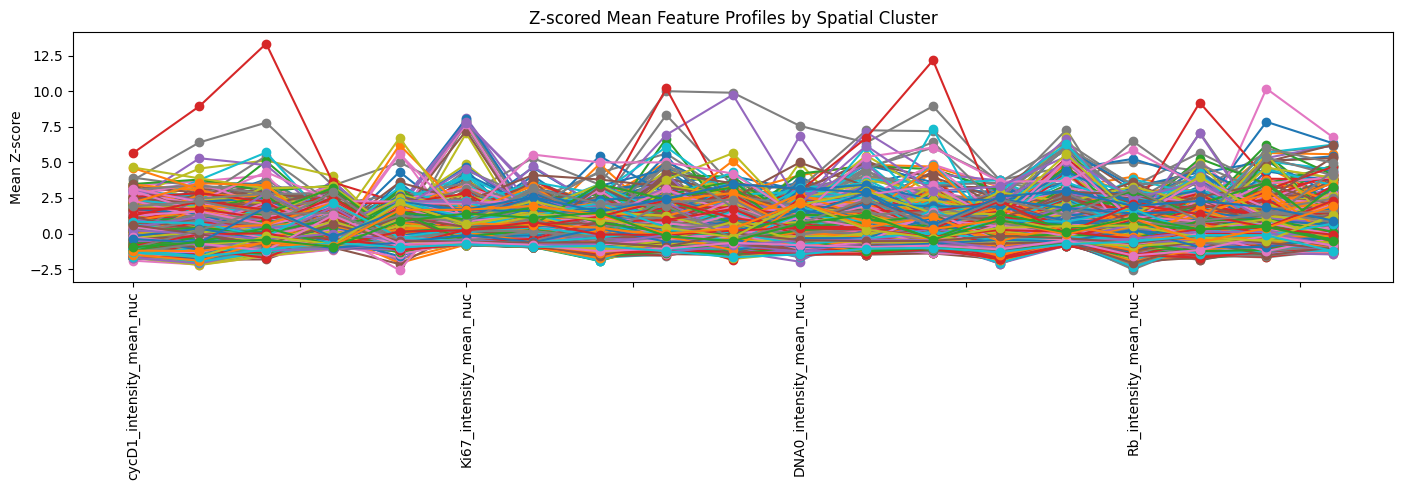

In [8]:
from sklearn.feature_selection import f_oneway


top_20_features = [
    'cycD1_intensity_mean_nuc',
    'E2F1_intensity_mean_nuc',
    'cycE1_intensity_mean_nuc',
    'Cdt1_intensity_mean_nuc',
    'dna_content',
    'Ki67_intensity_mean_nuc',
    'Geminin_intensity_mean_nuc',
    'pRb_intensity_mean_nuc',
    'ER_intensity_mean_nuc',
    'CDK4_intensity_mean_nuc',
    'DNA0_intensity_mean_nuc',
    'cycA2_intensity_mean_nuc',
    'p21_intensity_mean_nuc',
    'CDK2_intensity_mean_nuc',
    'cycB1_intensity_mean_nuc',
    'Rb_intensity_mean_nuc',
    'PR_intensity_mean_nuc',
    'Mdm2_intensity_mean_nuc',
    'EGFR_intensity_mean_nuc'
]

def analyze_spatial_clusters(df, features, cluster_col='spatial_cluster'):
    """
    Analyze and visualize feature differences across spatial clusters.

    Parameters:
        df (pd.DataFrame): DataFrame with features and spatial cluster labels.
        features (list): List of feature column names to analyze.
        cluster_col (str): Name of column indicating spatial clusters.
    """
    # Standardize features
    X_scaled = pd.DataFrame(
        StandardScaler().fit_transform(df[features]),
        columns=features,
        index=df.index
    )
    X_scaled[cluster_col] = df[cluster_col].values

    print("ANOVA results across spatial clusters:\n")
    for feat in features:
        groups = [g[feat].values for _, g in X_scaled.groupby(cluster_col)]
        F, p = f_oneway(*groups)
        print(f"{feat:35s} F={F.item():8.2f}, p={p.item():.2e}")

    cluster_means = X_scaled.groupby(cluster_col)[features].mean().T
    cluster_means.plot(kind='line', figsize=(14, 5), marker='o', legend=False)
    plt.title("Z-scored Mean Feature Profiles by Spatial Cluster")
    plt.ylabel("Mean Z-score")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

analyze_spatial_clusters(resistant_cells, top_20_features)

ANOVA results explain how much the expression of each marker varies across spatial clusters of resistant cells. Proteins like Mdm2, cycE1, ER, EGFR, etc are spatially heterogeneous. Their expression is not uniform across the tissue or cell cluster. This may suggest localized functional zones within resistant cell populations, potentially tied to microenvironmental effects or lineage differences. ki67 (a proliferation marker) is more evenly distributed across spatial clusters, suggesting that proliferation status doesn't vary much spatially in resistant cells.

## Estimate DBSCAN "eps" Based on Nearest Neighbor Distances in Control Cells

Recommended eps from 1st–3rd NN (25th percentile): 95.91


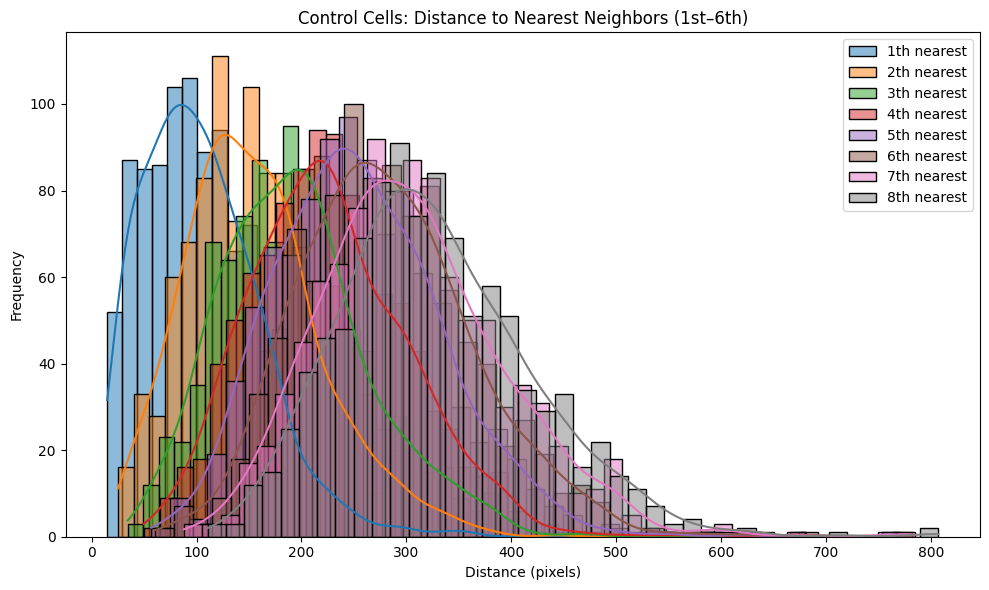

In [9]:
from sklearn.neighbors import NearestNeighbors

control_cells = data[data['palbo_condition'] == 'control'].copy()
coords = control_cells[['centroid-0_nuc_r0', 'centroid-1_nuc_r0']].dropna().to_numpy()

# subsample to from full df
if len(coords) > 1000:
    coords = coords[np.random.choice(len(coords), 1000, replace=False)]

# Nearest neighbors
k = 8
nn = NearestNeighbors(n_neighbors=k+1)  
nn.fit(coords)
distances, _ = nn.kneighbors(coords)
neighbor_dists = distances[:, 1:]  

# Compute robust epsilon using lower percentiles of 1st–3rd neighbors
subset_dists = neighbor_dists[:, :3]  # 1st–3rd neighbors
flat_dists = subset_dists.flatten()
eps = np.percentile(flat_dists, 25)  # 25th percentile is conservative
print(f"Recommended eps from 1st–3rd NN (25th percentile): {eps:.2f}")

plt.figure(figsize=(10, 6))
for i in range(k):
    sns.histplot(neighbor_dists[:, i], label=f"{i+1}th nearest", bins=40, kde=True)

plt.xlabel("Distance (pixels)")
plt.ylabel("Frequency")
plt.title("Control Cells: Distance to Nearest Neighbors (1st–6th)")
plt.legend()
plt.tight_layout()
plt.show()

## DBSCAN on Resistant Cells with Size Thresholding

 Kept 2547 cells in 720 clusters (≤ 20 cells per cluster)
count    720.000000
mean       3.537500
std        3.878364
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       20.000000
Name: count, dtype: float64


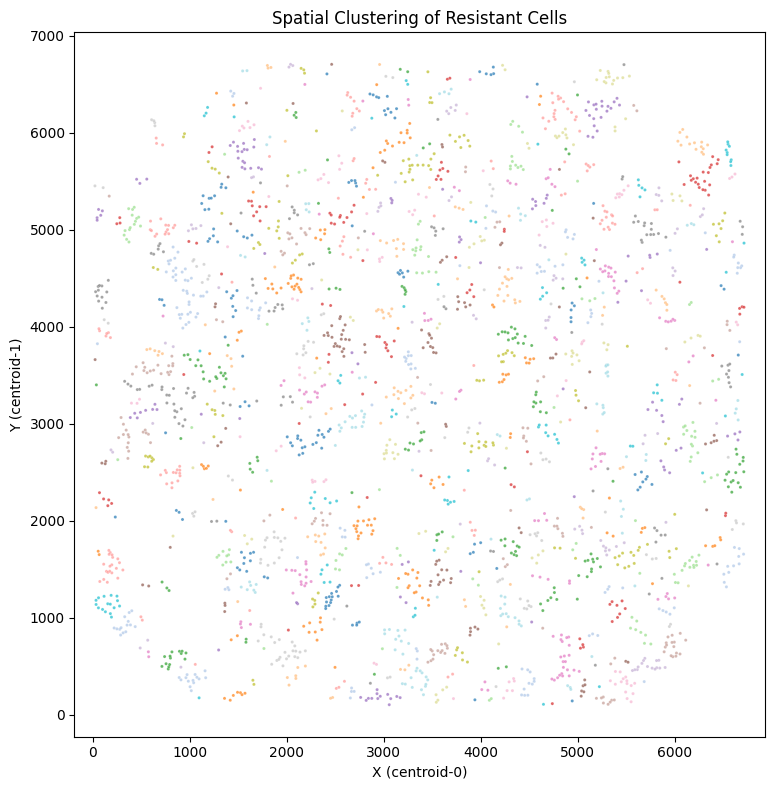

In [10]:
# Filter for resistant cells (palbo-treated & cycling)
resistant_cells = data[(data['palbo_condition'] == 'palbo') & (data['cycling_bool'] == 1)].copy()

# Run DBSCAN
coords = resistant_cells[['centroid-0_nuc_r0', 'centroid-1_nuc_r0']].dropna().to_numpy()
dbscan_spatial = DBSCAN(eps= 89.93, min_samples=1) 
resistant_cells['spatial_cluster'] = dbscan_spatial.fit_predict(coords)

MAX_CLUSTER_SIZE = 20

cluster_counts = resistant_cells['spatial_cluster'].value_counts()

valid_clusters = cluster_counts[cluster_counts <= MAX_CLUSTER_SIZE].index

filtered_cells = resistant_cells[resistant_cells['spatial_cluster'].isin(valid_clusters)].copy()

print(f" Kept {len(filtered_cells)} cells in {len(valid_clusters)} clusters (≤ {MAX_CLUSTER_SIZE} cells per cluster)")

filtered_cluster_sizes = filtered_cells['spatial_cluster'].value_counts().sort_index()
print(filtered_cluster_sizes.describe())

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x='centroid-0_nuc_r0',
    y='centroid-1_nuc_r0',
    hue='spatial_cluster',
    data=filtered_cells,
    palette='tab20',
    s=5,
    alpha=0.7,
    legend=False  
)
plt.title("Spatial Clustering of Resistant Cells")
plt.xlabel("X (centroid-0)")
plt.ylabel("Y (centroid-1)")
plt.axis('equal')
plt.tight_layout()
plt.show()

Feature Extraction and Standardization

In [ ]:
feature_cols = [col for col in filtered_cells.columns 
                if col.endswith('_mean_nuc') or col.endswith('_mean_cyto')]
X = filtered_cells[feature_cols].copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dimensionality Reduction via PCA

In [ ]:
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

print(f"Retained {X_pca.shape[1]} PCA components")
filtered_cells_pca = filtered_cells.copy()
filtered_cells_pca[[f"PC{i+1}" for i in range(X_pca.shape[1])]] = X_pca

Retained 10 PCA components


Performed PCA on standardized intensity features to reduce dimensionality while preserving 90% of the variance. Retained 10 PCA components and appended them to the filtered dataframe.

## Intra-Cluster Variability in PCA Space

In [13]:
intra_variability = []

for cluster_id, group in filtered_cells_pca.groupby('spatial_cluster'):
    coords = group[[f"PC{i+1}" for i in range(X_pca.shape[1])]].to_numpy()
    if len(coords) > 1:
        avg_distance = pdist(coords).mean()
    else:
        avg_distance = 0  # Singleton clusters
    intra_variability.append({'cluster_id': cluster_id, 'intra_dist': avg_distance, 'size': len(coords)})

intra_df = pd.DataFrame(intra_variability)

Inter-Cluster Distances Based on PCA Centroids

In [ ]:
centroids = filtered_cells_pca.groupby('spatial_cluster')[[f"PC{i+1}" for i in range(X_pca.shape[1])]].mean()

# Pairwise distances between centroids
centroid_distances = pdist(centroids.to_numpy())
inter_df = pd.DataFrame({'inter_dist': centroid_distances})

Computed the mean PCA coordinates(centroids) for each spatial cluster and calculated all pairwise distances between these centroids to assess how far apart clusters are from each other in feature space.

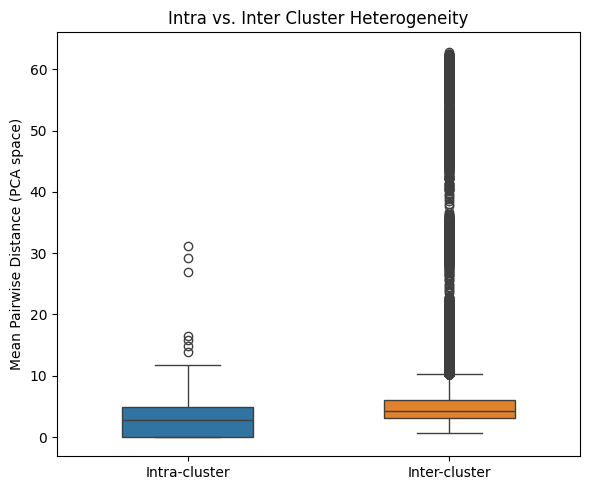

In [15]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=[intra_df['intra_dist'], inter_df['inter_dist']], width=0.5)
plt.xticks([0, 1], ['Intra-cluster', 'Inter-cluster'])
plt.ylabel("Mean Pairwise Distance (PCA space)")
plt.title("Intra vs. Inter Cluster Heterogeneity")
plt.tight_layout()
plt.show()

The clusters have small intra-cluster distances, but have larger inter-cluster distances, which shows meaningful clustering.

## Compute Pairwise Distances Between Points Across Different Spatial Clusters
intra = avg pairwise distance within a cluster
inter = avg pairwise distance between points from different clusters

In [16]:
clusters = list(filtered_cells_pca['spatial_cluster'].unique())
inter_pairs = list(combinations(clusters, 2))

inter_data = []

for c1, c2 in inter_pairs:
    group1 = filtered_cells_pca[filtered_cells_pca['spatial_cluster'] == c1]
    group2 = filtered_cells_pca[filtered_cells_pca['spatial_cluster'] == c2]
    
    coords1 = group1[[f"PC{i+1}" for i in range(X_pca.shape[1])]].to_numpy()
    coords2 = group2[[f"PC{i+1}" for i in range(X_pca.shape[1])]].to_numpy()
    
    # Compute cross-cluster pairwise distances
    inter_dists = cdist(coords1, coords2).flatten()
    
    inter_data.append(pd.Series(inter_dists))

inter_all = pd.concat(inter_data, ignore_index=True)

Visualise Intra- vs Inter-Cluster Distance Distributions

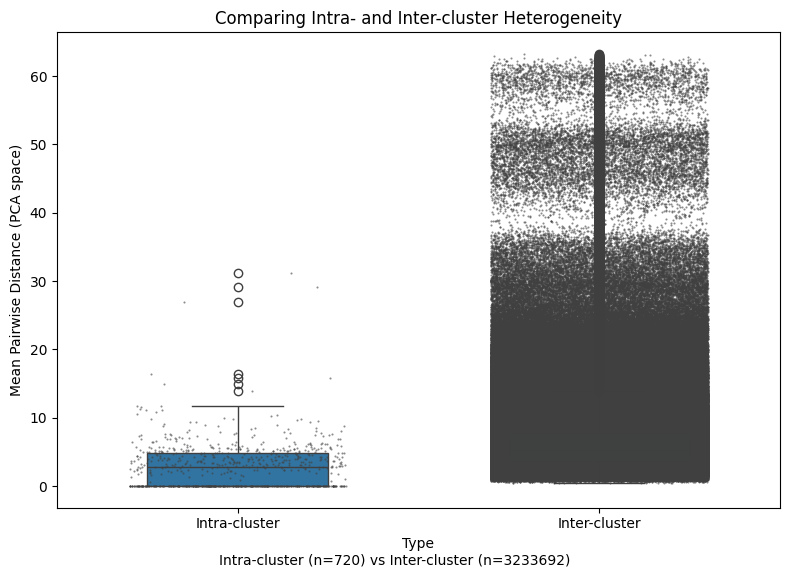

In [17]:
plot_df = pd.concat([
    pd.DataFrame({'Distance': intra_df['intra_dist'], 'Type': 'Intra-cluster'}),
    pd.DataFrame({'Distance': inter_all, 'Type': 'Inter-cluster'})
])

intra_count = len(intra_df['intra_dist'])
inter_count = len(inter_all)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=plot_df, width=0.5)
sns.stripplot(x='Type', y='Distance', data=plot_df, 
              color=".25", size=1.5, jitter=0.3, alpha=0.6)

plt.ylabel("Mean Pairwise Distance (PCA space)")
plt.title("Comparing Intra- and Inter-cluster Heterogeneity")

plt.suptitle(f"Intra-cluster (n={intra_count}) vs Inter-cluster (n={inter_count})", 
             fontsize=10, y=0.02)

plt.tight_layout()
plt.show()

Above diagram tells us that there is strong clustering - complete seperatioin between intra and inter-cluster distances shows the clustering algorithm found meaningful, distinct groups. 
Low intra-cluster distances mean points within each cluster are very similar. 
High inter-cluster distances mean the clusters are distinct from each other. 
The variation in inter-cluster distances indicates different levels of cluster separation. The presence of distinct groupings in the inter-cluster points suggests that while some clusters are clearly separated, others are more similar or closely related, reflecting a hierarchy or gradation in cluster distinctness.

Cohen's d for standardized mean difference between intra- and inter-cluster distances.

In [18]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(
        ((nx - 1)*x.std(ddof=1)**2 + (ny - 1)*y.std(ddof=1)**2) / dof
    )
    return (x.mean() - y.mean()) / pooled_std

d = cohen_d(
    plot_df[plot_df['Type'] == 'Intra-cluster']['Distance'],
    plot_df[plot_df['Type'] == 'Inter-cluster']['Distance']
)

print(f"Cohen's d (effect size): {d:.2f}")

Cohen's d (effect size): -0.74


Cohen’s d of -0.73 indicates a medium-to-large effect size, confirming that intra-cluster points are substantially closer together compared to inter-cluster points, supporting good cluster separation.

/var/folders/bk/5_15qn8s2qg0rwywtw8sjc240000gn/T/ipykernel_41003/3167693344.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Distance', data=plot_df, inner='box', cut=0, palette='Set2')


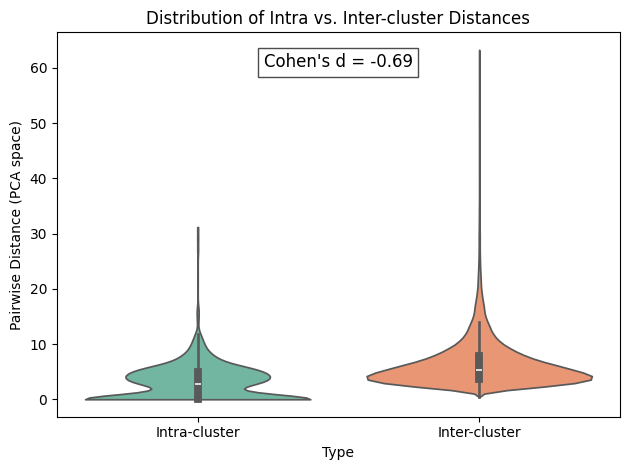

In [19]:
sns.violinplot(x='Type', y='Distance', data=plot_df, inner='box', cut=0, palette='Set2')
plt.ylabel("Pairwise Distance (PCA space)")
plt.title("Distribution of Intra vs. Inter-cluster Distances")

plt.text(0.5, max(plot_df['Distance'])*0.95, "Cohen's d = -0.69", ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

The violin plot confirms that points inside clusters are closer together on average, while points from different clusters tend to be farther apart, but there's some variation in the degree of cluster seperation.

In [ ]:
from sklearn.metrics import pairwise_distances

coords_cols = ['centroid-0_nuc_r0', 'centroid-1_nuc_r0']
cluster_col = 'spatial_cluster'

cluster_stds = []
for cluster_id, group in filtered_cells.groupby(cluster_col):
    X = group[coords_cols].values
    if len(X) < 2:
        continue
    dists = pairwise_distances(X)
    triu = np.triu_indices_from(dists, k=1)
    pairwise_std = np.std(dists[triu])
    cluster_stds.append(pairwise_std)

avg_cluster_std = float(np.mean(cluster_stds))
print("avg_cluster_std (spatial, 2D):", avg_cluster_std)

avg_cluster_std (spatial, 2D): 28.770428417944157


In [ ]:
from sklearn.datasets import make_blobs

n_samples = len(filtered_cells)
n_clusters = filtered_cells[cluster_col].nunique()
sim_coords, sim_labels = make_blobs(
    n_samples=n_samples,
    n_features=2,
    centers=n_clusters,
    cluster_std=avg_cluster_std,
    random_state=42
)
sim_df = pd.DataFrame(sim_coords, columns=coords_cols)
sim_df['spatial_cluster'] = sim_labels
sim_df['Condition'] = 'Simulated'

real_df = filtered_cells[coords_cols].copy()
real_df = real_df.reset_index(drop=True)
real_df['spatial_cluster'] = filtered_cells[cluster_col].values
real_df['Condition'] = 'Real'

rand_df = real_df.copy()
np.random.seed(42)
rand_df['spatial_cluster'] = np.random.permutation(rand_df['spatial_cluster'].values)
rand_df['Condition'] = 'Randomized'

def calc_intra_distances(df, coord_cols=['centroid-0_nuc_r0','centroid-1_nuc_r0']):
    rows = []
    for cid, g in df.groupby('spatial_cluster'):
        coords = g[coord_cols].to_numpy()
        if coords.shape[0] < 2:
            continue
        avg_pair = pdist(coords).mean()
        rows.append({'Distance': avg_pair, 'Type': 'Intra-cluster', 'Condition': df['Condition'].iloc[0]})
    return pd.DataFrame(rows)

def calc_inter_distances(df, coord_cols=['centroid-0_nuc_r0','centroid-1_nuc_r0']):
    rows = []
    clusters = df['spatial_cluster'].unique()
    for c1, c2 in combinations(clusters, 2):
        p1 = df[df['spatial_cluster']==c1][coord_cols].to_numpy()
        p2 = df[df['spatial_cluster']==c2][coord_cols].to_numpy()
        if p1.size == 0 or p2.size == 0:
            continue
        dists = cdist(p1, p2).flatten()
        rows.extend([{'Distance': d, 'Type':'Inter-cluster', 'Condition': df['Condition'].iloc[0]} for d in dists])
    return pd.DataFrame(rows)

intra_real = calc_intra_distances(real_df)
inter_real = calc_inter_distances(real_df)

intra_sim = calc_intra_distances(sim_df)
inter_sim = calc_inter_distances(sim_df)

intra_rand = calc_intra_distances(rand_df)
inter_rand = calc_inter_distances(rand_df)

combined_df = pd.concat([intra_real, inter_real, intra_sim, inter_sim, intra_rand, inter_rand], ignore_index=True)

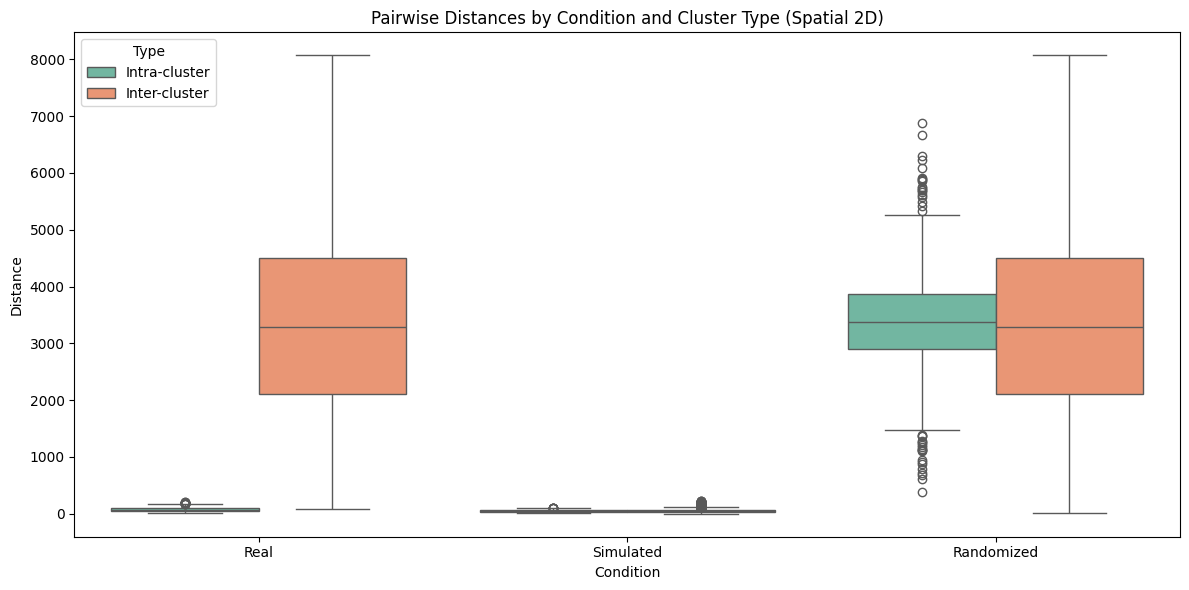

In [22]:
plt.figure(figsize=(12,6))
sns.boxplot(data=combined_df, x='Condition', y='Distance', hue='Type', palette='Set2')
plt.yscale('linear')  # try 'log' if needed
plt.title('Pairwise Distances by Condition and Cluster Type (Spatial 2D)')
plt.tight_layout()
plt.show()

Comparison of intra- and inter-cluster pairwise distances across real, simulated, and randomized conditions. Simulated clusters (Gaussian blobs) show tight intra-cluster compactness and high inter-cluster separation (Cohen’s d ≈ –5.7), while randomized cluster assignments show no clear structure (d ≈ 0). Real data demonstrates meaningful clustering (d ≈ –0.8), confirming the presence of biologically relevant spatial structure.

In [ ]:
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

real_intra = intra_real['Distance']
rand_intra = intra_rand['Distance']
sim_intra = intra_sim['Distance']

d_real_rand = cohen_d(real_intra, rand_intra)
d_real_sim = cohen_d(real_intra, sim_intra)
d_rand_sim = cohen_d(rand_intra, sim_intra)

print(f"Cohen's d (Real vs Randomized): {d_real_rand:.2f}")
print(f"Cohen's d (Real vs Simulated): {d_real_sim:.2f}")
print(f"Cohen's d (Randomized vs Simulated): {d_rand_sim:.2f}")

Cohen's d (Real vs Randomized): -4.47
Cohen's d (Real vs Simulated): 1.09
Cohen's d (Randomized vs Simulated): 5.22


Real clusters are significantly more compact than randomized clusters (Cohen’s d = -4.47), showing meaningful spatial structure. They are also slightly more compact than simulated clusters (Cohen’s d = 1.09). Randomized clusters are much less defined than simulated ones (Cohen’s d = 5.22), confirming the clustering reflects real biological patterns.

## In real space

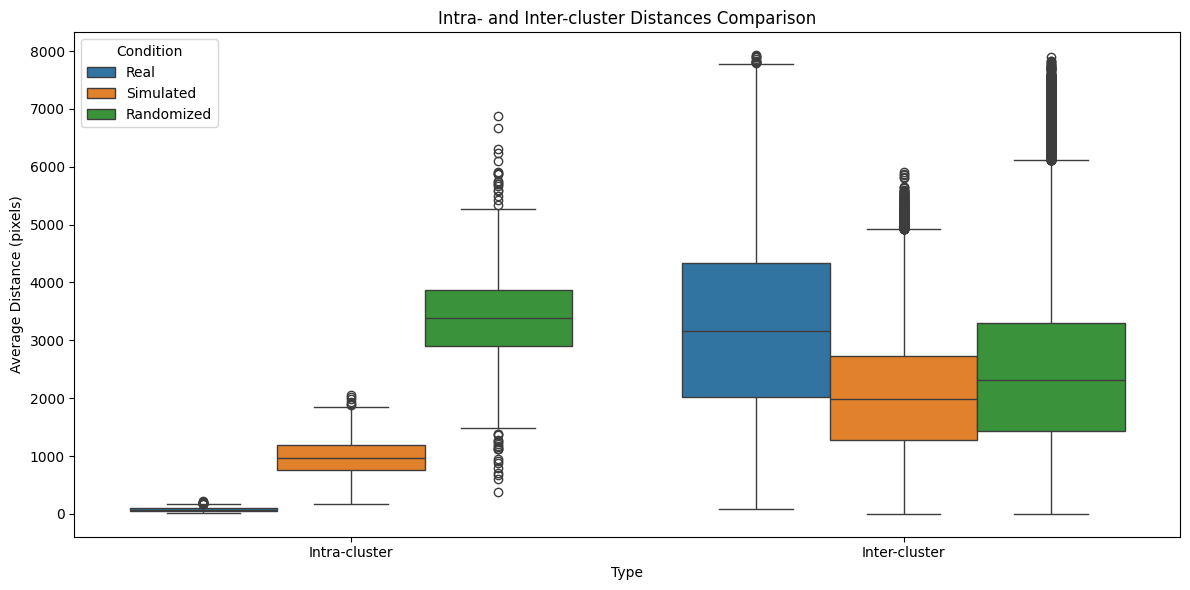

Summary Statistics:
                             count         mean          std         min  \
Type          Condition                                                    
Inter-cluster Randomized  258840.0  2454.392869  1318.467716    1.943003   
              Real        258840.0  3214.566859  1519.468211   90.269006   
              Simulated   258840.0  2031.667084   975.086021    2.923797   
Intra-cluster Randomized     430.0  3386.726669  1044.330355  380.330869   
              Real           430.0    81.225081    39.395143   16.580321   
              Simulated      720.0   986.396482   321.671795  170.359343   

                                  25%          50%          75%          max  
Type          Condition                                                       
Inter-cluster Randomized  1434.439557  2306.318533  3306.142173  7896.632038  
              Real        2025.879754  3155.789790  4335.902404  7927.844964  
              Simulated   1273.178374  1988.427388  273

In [ ]:
coord_cols = ['centroid-0_nuc_r0', 'centroid-1_nuc_r0']

real_df = filtered_cells.copy()
real_df['Condition'] = 'Real'
n_clusters = real_df['spatial_cluster'].nunique()
n_samples = len(real_df)

real_coords = real_df[coord_cols].to_numpy()
real_std = np.std(real_coords, axis=0).mean()
real_center = np.mean(real_coords, axis=0)

sim_coords, sim_labels = make_blobs(
    n_samples=n_samples,
    n_features=2,
    centers=n_clusters,
    cluster_std=real_std * 0.3,  # Adjust this multiplier as needed
    center_box=(real_center[0] - real_std, real_center[0] + real_std,
                real_center[1] - real_std, real_center[1] + real_std),
    random_state=42
)
sim_df = pd.DataFrame(sim_coords, columns=coord_cols)
sim_df['spatial_cluster'] = sim_labels
sim_df['Condition'] = 'Simulated'

rand_df = real_df.copy()
np.random.seed(42)
rand_df['spatial_cluster'] = np.random.permutation(rand_df['spatial_cluster'].values)
rand_df['Condition'] = 'Randomized'

min_cluster_size = 2
for df in [real_df, sim_df, rand_df]:
    valid_clusters = df['spatial_cluster'].value_counts()
    valid_clusters = valid_clusters[valid_clusters >= min_cluster_size].index
    df = df[df['spatial_cluster'].isin(valid_clusters)]

# Function to compute average intra-cluster distances
def calc_intra_distances(df):
    intra_distances = []
    for cid, group in df.groupby('spatial_cluster'):
        if len(group) > 1:
            coords = group[coord_cols].to_numpy()
            avg_dist = pdist(coords).mean()
            intra_distances.append(avg_dist)
    return intra_distances

def calc_inter_distances(df):
    # Calculate cluster centroids
    centroids = df.groupby('spatial_cluster')[coord_cols].mean()
    
    # Calculate distances between all pairs of centroids
    inter_distances = []
    for c1, c2 in combinations(centroids.index, 2):
        dist = np.linalg.norm(centroids.loc[c1] - centroids.loc[c2])
        inter_distances.append(dist)
    
    return inter_distances

results = []

for df_name, df in [('Real', real_df), ('Simulated', sim_df), ('Randomized', rand_df)]:
    intra_dists = calc_intra_distances(df)
    for dist in intra_dists:
        results.append({
            'Distance': dist,
            'Type': 'Intra-cluster',
            'Condition': df_name
        })
    
    inter_dists = calc_inter_distances(df)
    for dist in inter_dists:
        results.append({
            'Distance': dist,
            'Type': 'Inter-cluster', 
            'Condition': df_name
        })

combined_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='Type', y='Distance', hue='Condition')
plt.title("Intra- and Inter-cluster Distances Comparison")
plt.ylabel("Average Distance (pixels)")
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(combined_df.groupby(['Type', 'Condition'])['Distance'].describe())

## k means justification

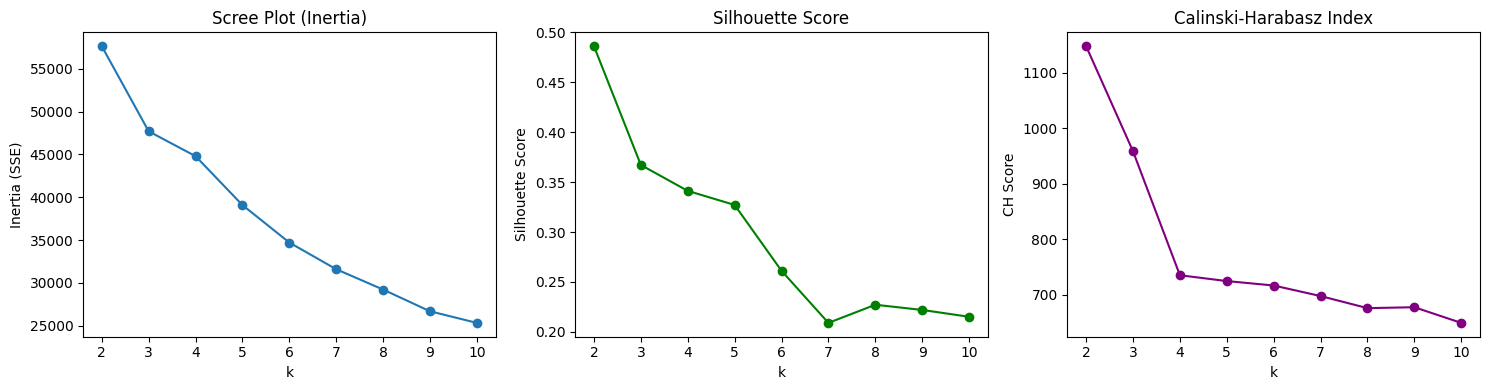

Best k by Silhouette Score: 2 (0.486)
Best k by Calinski-Harabasz Index: 2 (1147.408)
k=2: Silhouette=0.486, CH Index=1147.4
k=3: Silhouette=0.367, CH Index=958.2
k=4: Silhouette=0.341, CH Index=735.0
k=5: Silhouette=0.327, CH Index=724.5
k=6: Silhouette=0.261, CH Index=716.5
k=7: Silhouette=0.209, CH Index=697.5
k=8: Silhouette=0.227, CH Index=675.8
k=9: Silhouette=0.222, CH Index=677.4
k=10: Silhouette=0.215, CH Index=649.2


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
silhouette_scores = []
ch_scores = []

K_range = range(2, 11)  # silhouette and CH undefined for k=1

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca)
    
    sse.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))
    ch_scores.append(calinski_harabasz_score(X_pca, labels))

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(K_range, sse, marker='o')
plt.title('Scree Plot (Inertia)')
plt.xlabel('k')
plt.ylabel('Inertia (SSE)')

plt.subplot(1, 3, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 3)
plt.plot(K_range, ch_scores, marker='o', color='purple')
plt.title('Calinski-Harabasz Index')
plt.xlabel('k')
plt.ylabel('CH Score')

plt.tight_layout()
plt.show()

best_sil_k = K_range[silhouette_scores.index(max(silhouette_scores))]
best_ch_k = K_range[ch_scores.index(max(ch_scores))]

print(f"Best k by Silhouette Score: {best_sil_k} ({max(silhouette_scores):.3f})")
print(f"Best k by Calinski-Harabasz Index: {best_ch_k} ({max(ch_scores):.3f})")

for k, sil, ch in zip(K_range, silhouette_scores, ch_scores):
    print(f"k={k}: Silhouette={sil:.3f}, CH Index={ch:.1f}")


While the silhouette score peaked at k = 2, this solution did not capture the biological or spatial complexity observed in the data. The Elbow Method suggested an elbow at k = 4, which aligned better with the expected number of distinct spatial clusters. Visual inspection of the PCA plots confirmed that k = 4 provided a more granular and interpretable segmentation. Therefore, k = 4 was selected for K-means clustering.

## identifying resistant cell types

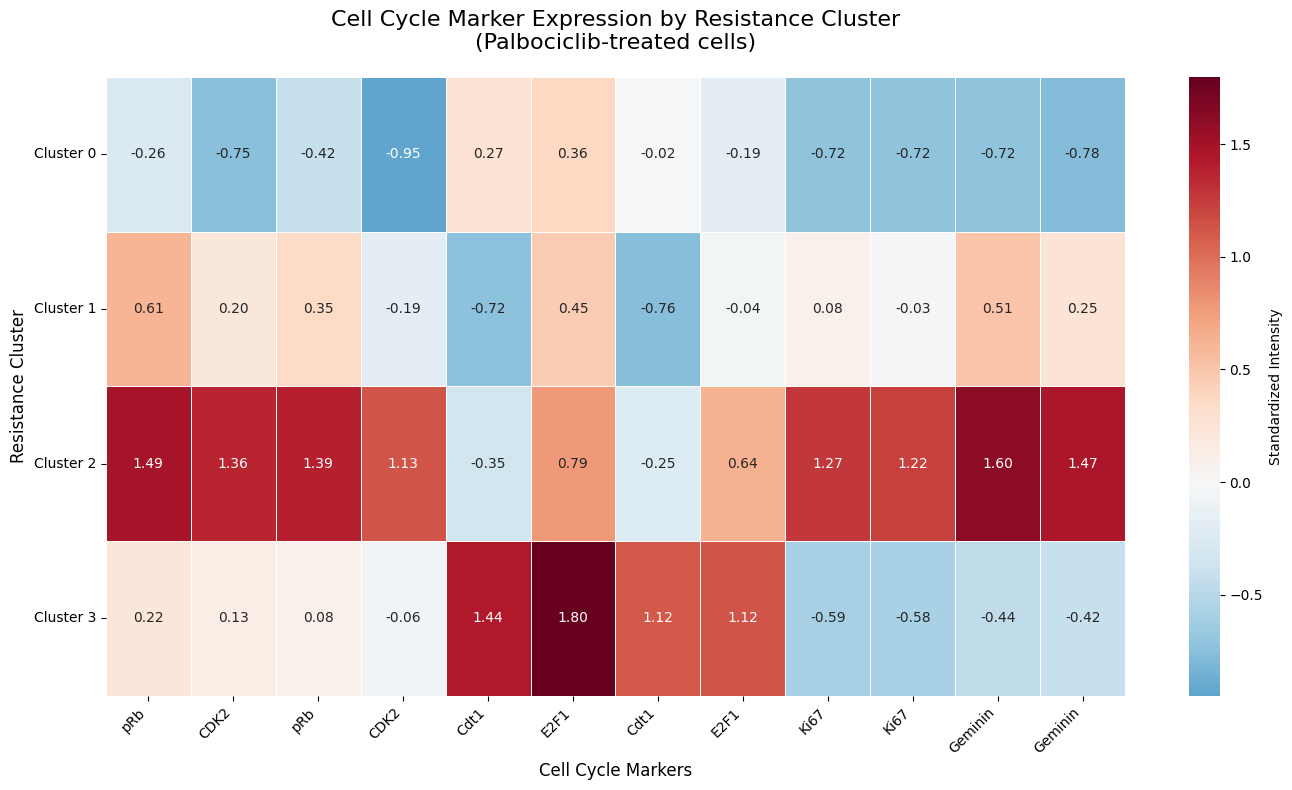

Cluster composition:
Cluster 0: 1598 cells (39.3%)
Cluster 1: 1447 cells (35.6%)
Cluster 2: 412 cells (10.1%)
Cluster 3: 605 cells (14.9%)

Biological interpretation guide:
• High pRb (phospho-Rb): Active cell cycle progression
• High CDK2: S-phase activity
• High Ki67: Proliferation marker
• High E2F1: G1/S transition
• High Cdt1: DNA replication licensing
• High Geminin: S/G2 phase, blocks re-replication
• High Cyclin: Cell cycle progression (depends on cyclin type)


In [ ]:
palbo_cells = data[(data['palbo_condition'] == 'palbo') & (data['cycling_bool'] == True)].copy()

features = [col for col in data.columns if (
    'intensity_mean' in col and
    ('nuc' in col or 'wc' in col) and
    any(marker in col for marker in ['pRb', 'CDK2', 'Ki67', 'Cdt1', 'Geminin', 'E2F1', 'cyclin'])
)]

X = palbo_cells[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

X_pca = PCA(n_components=0.9).fit_transform(X_scaled)

kmeans = KMeans(n_clusters=4, random_state=42).fit(X_pca)
palbo_cells.loc[X.index, 'resistance_cluster'] = kmeans.labels_

cluster_means = palbo_cells.groupby('resistance_cluster')[features].mean()

def clean_feature_name(feature_name):
    """Convert technical feature names to readable labels"""
    markers = ['pRb', 'CDK2', 'Ki67', 'Cdt1', 'Geminin', 'E2F1', 'cyclin']
    marker = None
    for m in markers:
        if m.lower() in feature_name.lower():
            marker = m
            break
    
    if '_nuc_' in feature_name:
        location = 'Nuclear'
    elif '_wc_' in feature_name:
        location = 'Whole Cell'
    else:
        location = ''
    
    if marker and location:
        return f"{marker} ({location})"
    elif marker:
        return marker
    else:
        return feature_name

clean_columns = [clean_feature_name(col) for col in cluster_means.columns]
cluster_means_clean = cluster_means.copy()
cluster_means_clean.columns = clean_columns

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_means_clean, 
           cmap='RdBu_r',  # Red-Blue colormap (red for high, blue for low)
           center=0, 
           annot=True, 
           fmt='.2f',
           cbar_kws={'label': 'Standardized Intensity'},
           linewidths=0.5)

plt.title("Cell Cycle Marker Expression by Resistance Cluster\n(Palbociclib-treated cells)", 
          fontsize=16, pad=20)
plt.xlabel("Cell Cycle Markers", fontsize=12)
plt.ylabel("Resistance Cluster", fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
plt.gca().set_yticklabels(cluster_labels)

plt.tight_layout()
plt.show()

print("Cluster composition:")
total_cells = len(palbo_cells.dropna(subset=['resistance_cluster']))
for i in range(4):
    size = sum(palbo_cells['resistance_cluster'] == i)
    percentage = (size / total_cells) * 100 if total_cells > 0 else 0
    print(f"Cluster {i}: {size} cells ({percentage:.1f}%)")

print("\nBiological interpretation guide:")
print("• High pRb (phospho-Rb): Active cell cycle progression")
print("• High CDK2: S-phase activity") 
print("• High Ki67: Proliferation marker")
print("• High E2F1: G1/S transition")
print("• High Cdt1: DNA replication licensing")
print("• High Geminin: S/G2 phase, blocks re-replication")
print("• High Cyclin: Cell cycle progression (depends on cyclin type)")


We clustered palbociclib-treated cells based on marker intensity features relevant to cell cycle and resistance. After standardization and PCA (retaining 90% of variance), we applied K-means clustering. The optimal number of clusters (k = 4) was chosen using the Elbow method, Silhouette score, and Calinski-Harabasz index.

Heatmaps of marker expression per cluster revealed biologically distinct subpopulations. Spatial plots further showed that clusters had distinct spatial distributions within the tissue, supporting the relevance of these phenotypes.

## Spatial Distribution of Clusters in XY Space

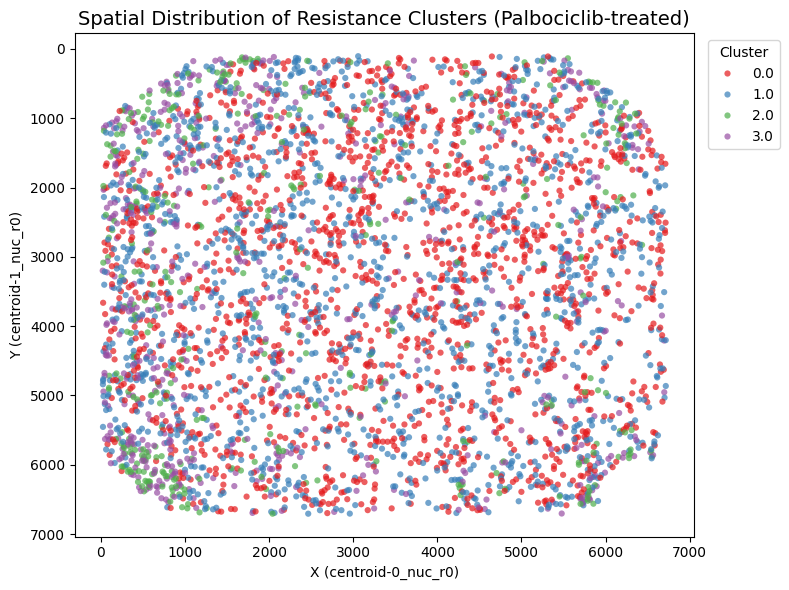

In [27]:
if 'centroid-0_nuc_r0' in palbo_cells.columns and 'centroid-1_nuc_r0' in palbo_cells.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=palbo_cells,
        x='centroid-0_nuc_r0',
        y='centroid-1_nuc_r0',
        hue='resistance_cluster',
        palette='Set1',
        s=20,
        linewidth=0,
        alpha=0.7
    )
    
    plt.gca().invert_yaxis()
    plt.title("Spatial Distribution of Resistance Clusters (Palbociclib-treated)", fontsize=14)
    plt.xlabel("X (centroid-0_nuc_r0)")
    plt.ylabel("Y (centroid-1_nuc_r0)")
    plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()
else:
    print("Centroid columns not found in palbo_cells.")